In [193]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import time

import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
from numpyro.infer import SVI, Trace_ELBO, Predictive
import numpyro.diagnostics

from termcolor import colored
import matplotlib.pyplot as plt

from pathlib import Path

import dill
import pickle
import arviz as az

from sklearn.preprocessing import QuantileTransformer

# GP Kernel Function

In [194]:
def dist_euclid(x, z):
    """
    Computes Eucledian Distance Between Regions. This function is used by
    exp_sq_kernel function (kernel function for gaussian processes)
    """
    x = jnp.array(x) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    z = jnp.array(z) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    n_x, m = x.shape # 7304 , 2
    n_z, m_z = z.shape # 7304 , 2
    assert m == m_z
    delta = jnp.zeros((n_x,n_z)) #(ngrid_pts,ngrid_pts) <- i.e (7304,7304)
    for d in jnp.arange(m):
        x_d = x[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        z_d = z[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        delta += (x_d[:,jnp.newaxis] - z_d)**2 # (7304,7304)

    return jnp.sqrt(delta) #(7304,7304)

In [195]:
def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z) #(7304, 7304)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k # (ngrid_pts, ngrid_pts) <- (7304,7304)


# Aggregation Functions

In [196]:
def M_g(M, g):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    return(jnp.matmul(M, g))

# Aggregated Prevalence Model - must edit this to include HDI, population density



In [197]:
def prev_model_gp_aggr(args):
    """Dengue prevalence model with a Gaussian Process"""

    x = args["x"]  # Spatial grid points: (num_grid_points, 2)
    gp_kernel = args["gp_kernel"]  # Gaussian Process kernel
    noise = args["noise"]
    jitter = args["jitter"]

    #aggregate pop_density tgt
    pop_density = args["pop_density"]

    #aggregate hdi tgt
    hdi = args["hdi"]

    urban = args["urban"]

    M_lo = args["M_lo"]  # (4, num_grid_points) aggregation matrix
    M_hi = args["M_hi"]  # (24, num_grid_points) aggregation matrix

    total_cases_lo = args["total_cases_lo"] #cos we wanna predict total cases district-wise, so only feed total cases for low res data

    total_population_lo = args["total_population_lo"]
    total_population_hi = args["total_population_hi"]

    #aggregate total populations low and high
    total_population = jnp.concatenate([total_population_lo,total_population_hi], axis = 0)

    #add NaN values to total_cases to accommodate for unavailable total cases data for high resolution (that we want to predict)
    total_cases = jnp.pad(total_cases_lo, (0, M_hi.shape[0]),constant_values = 0.0) #[3762.  484. ... , 0,0,0]
    total_cases = jnp.where(total_cases == 0, jnp.nan, total_cases)# [3762.  484. ... , nan,nan,nan]
    total_cases_mask = ~jnp.isnan(total_cases) # [True, True, ...., False, False, False]

    # GP hyperparameters
    kernel_length = numpyro.sample("kernel_length", args["kernel_length"])
    kernel_var = numpyro.sample("kernel_var", args["kernel_var"])

    # GP Kernel and Sample
    k = gp_kernel(x, x, kernel_var, kernel_length, noise, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))  # (num_grid_points,)

    # Aggregate GP values to district level
    gp_aggr_lo = numpyro.deterministic("gp_aggr_lo", M_g(M_lo, f))  # (4,)
    gp_aggr_hi = numpyro.deterministic("gp_aggr_hi", M_g(M_hi, f))  # (24,)

    # Now we need to aggregate both. This step is important since even though we only
    # show the model the low resolution data, to produce high resolution data it
    # needs the GP realizations for those regions
    gp_aggr = numpyro.deterministic("gp_aggr", jnp.concatenate([gp_aggr_lo,gp_aggr_hi])) #(28,)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(-5.25, 0.5))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 0.33))  # Effect of population density normal (2, 0.25) previously
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 0.33))  # Effect of HDI
    b_urban = numpyro.sample("b_urban", dist.Normal(0, 0.33))  # Effect of urbanicity

    #standardise all before passing into lp
    #pop_density = (pop_density - jnp.mean(pop_density)) / jnp.std(pop_density)
    #hdi = (hdi-jnp.mean(hdi)) / jnp.std(hdi)
    #urban = (urban - jnp.mean(urban)) / jnp.std(urban)

    # Linear predictor
    lp = numpyro.deterministic("lp", b0 - gp_aggr - b_pop_density * pop_density + b_hdi * hdi - b_urban * urban)  # (num_districts,)
    #lp = numpyro.deterministic("lp", (b0 - gp_aggr - b_pop_density * pop_density))  # (num_districts,)
    #lp = numpyro.deterministic("lp", (b0 - gp_aggr))  # (num_districts,)

    # Prevalence probability
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))  # (num_districts,)

    # Binomial likelihood
    with numpyro.handlers.mask(mask=total_cases_mask):
        pred_cases = numpyro.sample(
            "pred_cases",
            dist.Binomial(total_count=total_population, probs=theta),
            obs=total_cases)

    return pred_cases

# Load Data

In [198]:
# Lat/Lon Values of artificial grid
x = np.load("../data/lat_lon_x_jkt.npy")

# combined regional data
pol_pts_jkt_lo = np.load("../data/pol_pts_jkt_lo.npy")
pt_which_pol_jkt_lo = np.load("../data/pt_which_pol_jkt_lo.npy")
pol_pts_jkt_hi = np.load("../data/pol_pts_jkt_hi.npy")
pt_which_pol_jkt_hi = np.load("../data/pt_which_pol_jkt_hi.npy")

#combine the dataframes
df_lo = gpd.read_file("../data/jkt_prov.shp")
df_hi = gpd.read_file("../data/jkt_dist.shp")

In [199]:
df_lo['Year'].max()

np.int64(2023)

In [200]:
#filter to get one year only
df_lo = df_lo[df_lo["Year"] == 2023]
df_hi = df_hi[df_hi["Year"] == 2023]

In [201]:
print(df_lo.Pop_den)

3    1211.420223
Name: Pop_den, dtype: float64


# Vars needed to be changed (change according to the agg prevalence model parameters)

In [202]:
M_lo = jnp.array(pol_pts_jkt_lo)
M_hi = jnp.array(pol_pts_jkt_hi)
cases_lo = jnp.array(df_lo["Cases"])
pop_lo = jnp.array(df_lo["Population"])
pop_hi = jnp.array(df_hi["Population"])

In [203]:
#print the shape of all the vars above
print(M_lo.shape)
print(M_hi.shape)
print(cases_lo.shape)
print(pop_lo.shape)
print(pop_hi.shape)
print(x.shape)

(1, 100)
(5, 100)
(1,)
(1,)
(5,)
(100, 2)


### Prior Predictive Check

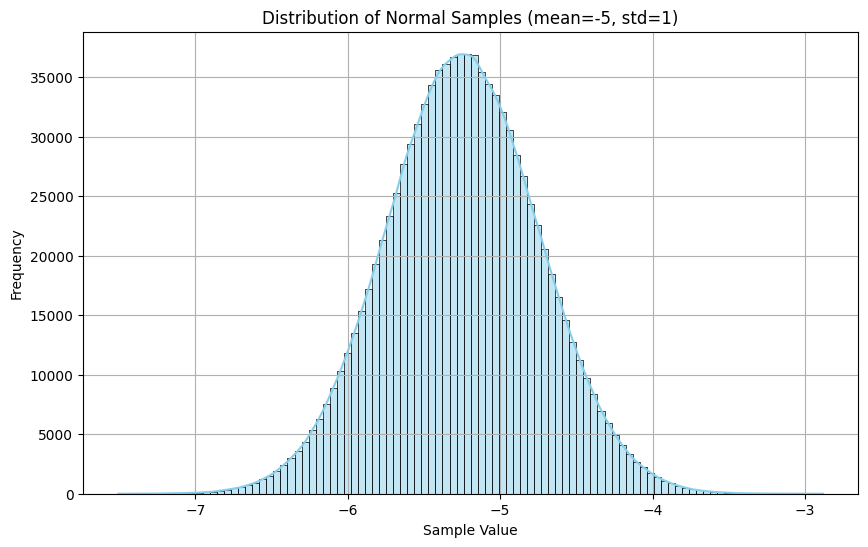

In [204]:
# Generate 1e+6 samples from a normal distribution with mean -5 and std 1, to make the values range between -3 and -7
samples = np.random.normal(loc=-5.25, scale=0.5, size=int(1e6))

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(samples, kde=True, color='skyblue', bins=100)
plt.title("Distribution of Normal Samples (mean=-5, std=1)")
plt.xlabel("Sample Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [205]:
# Prior Predictive Check
prior_samples = Predictive(prev_model_gp_aggr, num_samples=500)(
    random.PRNGKey(6), args)

# transform prior samples to arviz inference object
prior_samples_arviz = az.from_numpyro(prior=prior_samples)

In [206]:
az.summary(prior_samples_arviz, var_names = ["theta", "lp", "gp_aggr", "b0", "b_pop_density", "b_hdi", "b_urban"], stat_focus = "median")

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
theta[0],1.000,0.000,0.000,1.000,0.478,450.902,500.0,NaN
theta[1],0.004,0.004,0.000,1.000,0.002,416.989,514.0,NaN
theta[2],0.005,0.005,0.000,0.979,0.002,446.318,472.0,NaN
theta[3],0.004,0.004,0.000,1.000,0.003,500.016,526.0,NaN
theta[4],0.002,0.002,0.000,1.000,0.002,456.061,500.0,NaN
theta[5],0.002,0.002,0.000,1.000,0.001,458.526,500.0,NaN
lp[0],9.551,263.442,-713.885,726.724,19.936,450.902,437.0,NaN
lp[1],-5.654,6.606,-24.792,13.137,0.578,416.989,514.0,NaN
lp[2],-5.384,3.344,-15.139,3.844,0.352,446.318,472.0,NaN
lp[3],-5.576,7.947,-29.609,17.154,0.752,500.016,526.0,NaN


# Agg GP Model

In [207]:
pop_lo = jnp.array(df_lo["Pop_den"]) 
pop_hi = jnp.array(df_hi["Pop_den"]) 
hdi_lo = jnp.array(df_lo["HDI"])
hdi_hi = jnp.array(df_hi["HDI"])
urban_lo = jnp.array(df_lo["urbanicity"])
urban_hi = jnp.array(df_hi["urbanicity"])

pop_all = jnp.concatenate([pop_lo, pop_hi], axis=0)
hdi_all = jnp.concatenate([hdi_lo, hdi_hi], axis=0)
urban_all = jnp.concatenate([urban_lo, urban_hi], axis=0)

In [208]:
args = {
        "x" : jnp.array(x), # Lat/lon vals of grid points # Shape (num_districts, 2)
        "gp_kernel" : exp_sq_kernel,
        "jitter" : 1e-4,
        "noise" : 1e-4,
        "M_lo" : M_lo, # Aggregation matrix # Shape (num_districts, num_districts)
        "M_hi" : M_hi, # Aggregation matrix # Shape (num_districts, num_districts)
        # GP Kernel Hyperparams
        "kernel_length" : dist.InverseGamma(3, 3), #(,)
        "kernel_var" : dist.LogNormal(0, 0.5),
        "pop_density": jnp.array(pop_all), # Shape (num_districts,)
        "hdi": jnp.array(hdi_all), # Shape (num_districts, 2)
        "urban": jnp.array(urban_all),
        "total_cases_lo" : cases_lo,
        "total_population_lo" : pop_lo,
        "total_population_hi" : pop_hi
}


# Run MCMC

In [209]:
# Base seed for reproducibility
base_seed = 3  # Keep this fixed for full replicability


# MCMC settings
n_warm = 1000
n_samples = 2000

In [210]:
save_dir = Path.cwd().parent / "model weights" / "aggGP"

# Save Model

In [211]:
rng_key = jax.random.PRNGKey(base_seed)
mcmc = MCMC(
    NUTS(prev_model_gp_aggr),
    num_warmup=n_warm,
    num_samples=n_samples,
    num_chains=4  # Run all chains at once
)

start = time.time()
try:
    mcmc.run(rng_key, args)
    end = time.time()
    t_elapsed = end - start
    t_elapsed_min = round(t_elapsed / 60)
    print(f"Total time elapsed: {t_elapsed:.2f}s ({t_elapsed_min} min)")

    # Save full MCMC object
    f_path = f"{save_dir}/aggGP_4chains_nsamples_{n_samples}_tt{t_elapsed_min}min_thetascaled.pkl"
    os.makedirs(save_dir, exist_ok=True)
    with open(f_path, "wb") as file:
        dill.dump(mcmc, file)

    print(f"Saved full 4-chain MCMC object to {f_path}")

except Exception as e:
    print(f"Error occurred during multi-chain MCMC run: {e}")

C:\Users\jessi\AppData\Local\Temp\ipykernel_21400\1880162180.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
warmup:  20%|██        | 600/3000 [00:09<00:36, 65.86it/s, 15 steps of size 2.17e-01. acc. prob=0.79]  


KeyboardInterrupt: 

# Results Inference

In [ ]:
samples = mcmc.get_samples(group_by_chain= True)
mcmc.print_summary(exclude_deterministic = False)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     -3.55      2.98     -5.04     -5.82      1.55      2.03      7.30
          b_hdi      0.04      0.29      0.13     -0.50      0.47    110.94      1.03
  b_pop_density     -0.21      0.20     -0.15     -0.51     -0.01      6.03      1.23
        b_urban      0.09      0.34      0.13     -0.49      0.53      6.40      1.20
           f[0]      0.24      0.39      0.16     -0.27      0.79      2.42      2.96
           f[1]     -0.45      0.92     -0.07     -2.00      0.33      2.06      7.61
           f[2]      0.15      0.29      0.12     -0.41      0.44      3.20      2.46
           f[3]     -0.05      0.33     -0.08     -0.40      0.53      2.90      2.92
           f[4]     -0.42      0.89     -0.09     -1.88      0.60      2.10      7.84
           f[5]     -0.04      0.36     -0.11     -0.38      0.71      3.13      3.03
           f[6]     -0.40      0.88     -0.12     -1.

In [ ]:
#view the theta
samples["theta"]

Array([[[1.00000000e+00, 1.85961455e-01, 6.09336384e-02, 3.81801307e-01,
         6.85571909e-01, 3.33447963e-01],
        [1.00000000e+00, 1.90149948e-01, 6.19091317e-02, 3.78822237e-01,
         6.90627158e-01, 3.44273746e-01],
        [1.00000000e+00, 1.64565653e-01, 5.14929630e-02, 2.77499944e-01,
         6.11905575e-01, 2.67003179e-01],
        ...,
        [1.00000000e+00, 1.00936973e-02, 2.77337935e-02, 1.43070761e-02,
         2.07129851e-01, 1.13752991e-01],
        [1.00000000e+00, 1.12853069e-02, 3.10176797e-02, 1.59295239e-02,
         2.37015799e-01, 1.12776726e-01],
        [1.00000000e+00, 1.49845807e-02, 3.85608710e-02, 2.02826206e-02,
         2.99568802e-01, 1.64849594e-01]],

       [[1.00000000e+00, 8.46351124e-03, 7.00433925e-03, 6.38343161e-03,
         3.93445306e-02, 7.40720928e-02],
        [1.00000000e+00, 1.04090311e-02, 8.85490980e-03, 8.02219845e-03,
         5.64325117e-02, 1.33425623e-01],
        [1.00000000e+00, 7.36956391e-03, 6.88468665e-03, 6.613945

In [ ]:
#assess the R hat, ESS etc.,
n_lo = df_lo.shape[0]
n_hi = df_hi.shape[0]

ss = numpyro.diagnostics.summary(samples)
r = np.mean(ss["gp_aggr"]["n_eff"])
print(f"Average ESS for all aggGP effects : {round(r)}")

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

print(f"kernel_length R-hat : {round(ss['kernel_length']['r_hat'], 2)}")
print(f"kernel_var R-hat : {round(ss['kernel_var']['r_hat'],2)}")

Average ESS for all aggGP effects : 3
Average ESS for all aggGP-low effects : 3
Max r_hat for all aggGP-low : 3.440000057220459
Average ESS for all aggGP-high effects : 3
Max r_hat for all aggGP-high : 3.9700000286102295
kernel_length R-hat : 1.1100000143051147
kernel_var R-hat : 1.0499999523162842


In [ ]:
# Convert summary stats to a DataFrame for better readability
df_summary = pd.DataFrame.from_dict(ss, orient="index")
print(df_summary)

                                                            mean  \
b0                                                     -3.553722   
b_hdi                                                   0.040445   
b_pop_density                                          -0.208549   
b_urban                                                 0.093407   
f              [0.24104661, -0.45282727, 0.14868872, -0.05029...   
gp_aggr        [1.9004642, 1.6048719, -0.26989454, -0.7272129...   
gp_aggr_hi     [1.6048719, -0.26989454, -0.72721297, 0.929361...   
gp_aggr_lo                                           [1.9003885]   
kernel_length                                           1.276227   
kernel_var                                              1.051999   
lp             [247.13297, -4.9136095, -3.0188909, -2.6586733...   
theta          [1.0, 0.037450705, 0.2511081, 0.2769107, 0.140...   

                                                             std  \
b0                                             

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'kernel_var'}>,
        <Axes: title={'center': 'kernel_var'}>]], dtype=object)

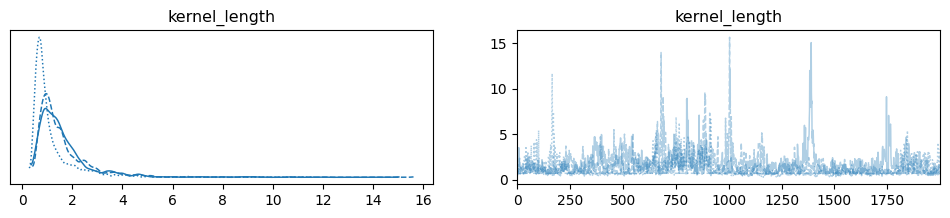

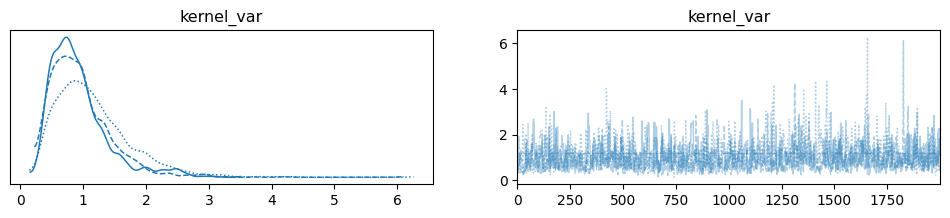

In [ ]:
# Convert manually combined samples into an ArviZ InferenceData object
case_samples_az_gp = az.from_dict(posterior=samples)

# Plot trace plots for kernel_length and kernel_var
az.plot_trace(case_samples_az_gp, var_names=["kernel_length"])
az.plot_trace(case_samples_az_gp, var_names=["kernel_var"])

### Calculate and append observed and gp-estimated theta

In [ ]:
samples["theta"].shape

(4, 2000, 6)

In [ ]:
theta_mean_gp = samples["theta"].mean(axis = (0, 1))
#theta_mean_gp_scalar = theta_mean_gp.mean(axis=1)  # now shape: (n_obs,)

bci_gp_25 = np.quantile(samples["theta"],0.25,axis = (0, 1))
bci_gp_75 = np.quantile(samples["theta"],0.75, axis = (0, 1))

# Slice IQR values to match low-res and high-res
bci_lo_25 = bci_gp_25[:n_lo]
bci_lo_75 = bci_gp_75[:n_lo]

bci_hi_25 = bci_gp_25[n_lo:n_lo + n_hi]
bci_hi_75 = bci_gp_75[n_lo:n_lo + n_hi]


df_lo["obs_prev"] = df_lo["Cases"] / df_lo["Population"]
df_hi["obs_prev"] = df_hi["Cases"] / df_hi["Population"]

df_lo["theta_gp"] = theta_mean_gp[0:n_lo]
df_hi["theta_gp"] = theta_mean_gp[n_lo:n_lo + n_hi]

theta_obs_lo = df_lo["obs_prev"]
theta_gp_est_lo = df_lo["theta_gp"]
theta_obs_hi = df_hi["obs_prev"]
theta_gp_est_hi = df_hi["theta_gp"]

max_val_lo = np.max(np.concatenate([theta_obs_lo.values, theta_gp_est_lo.values]))
min_val_lo = np.min(np.concatenate([theta_obs_lo.values, theta_gp_est_lo.values]))

max_val_hi = np.max(np.concatenate([theta_obs_hi.values, theta_gp_est_hi.values]))
min_val_hi = np.min(np.concatenate([theta_obs_hi.values, theta_gp_est_hi.values]))

In [ ]:
print(df_hi["theta_gp"])

3     0.037451
7     0.251113
11    0.276909
15    0.140776
19    0.285522
Name: theta_gp, dtype: float32


In [ ]:
# Compute average observed prevalence for low-res districts
mean_obs_prev_hi = theta_obs_hi.mean()

# Compute average predicted prevalence (before scaling) for low-res districts
mean_pred_prev_hi = theta_gp_est_hi.mean()

# Compute scaling factor to calibrate predictions
theta_scaling_factor = mean_obs_prev_hi / mean_pred_prev_hi
print(theta_scaling_factor)


0.009986216657221757


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# High incidence districts
rmse_hi = mean_squared_error(theta_obs_hi, theta_gp_est_hi)
mae_hi = mean_absolute_error(theta_obs_hi, theta_gp_est_hi)
mae_pct_hi = 100 * np.mean(np.abs(theta_obs_hi - theta_gp_est_hi) / theta_obs_hi)

from scipy.stats import spearmanr
# Spearman correlation
corr, p_value = spearmanr(theta_obs_hi, theta_gp_est_hi)

print(rmse_hi)
print(mae_hi)
print(mae_pct_hi)
print("Spearman correlation aggVAE:", corr)
print("p-value: aggVAE", p_value)

0.04772051176145587
0.19637343502933766
10012.282438614156
Spearman correlation aggVAE: -0.7
p-value: aggVAE 0.1881204043741873


# Plot the map

## high-res

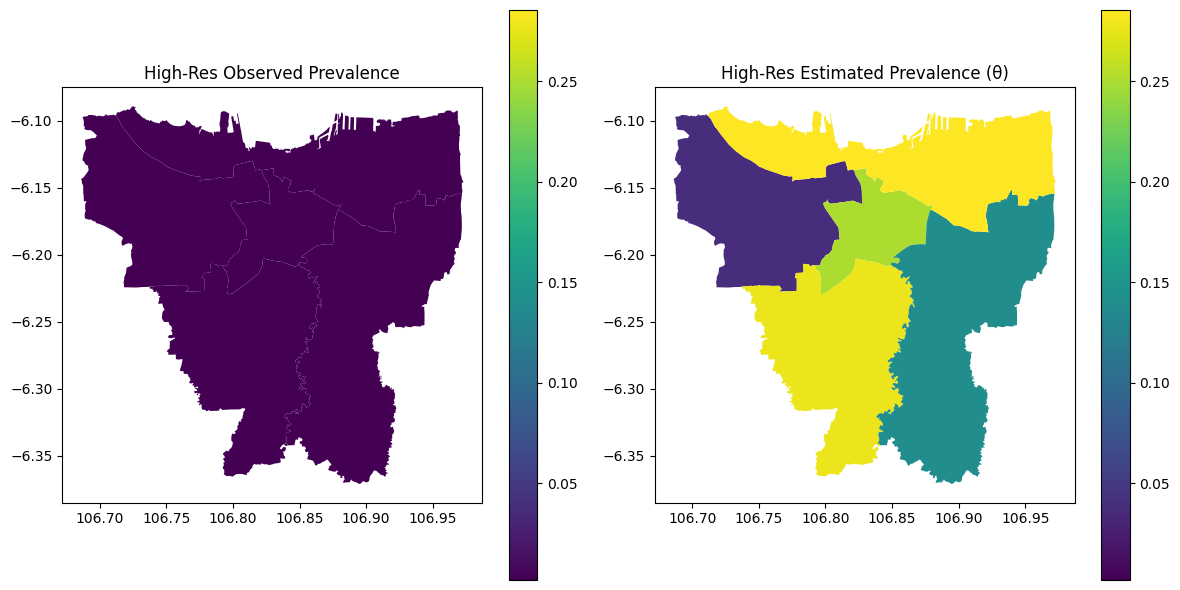

<Figure size 800x600 with 0 Axes>

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot observed prevalence on the map
df_hi.plot(
    column="obs_prev",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_hi,  # Minimum value for color scale
    vmax=max_val_hi,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[0],  # Plot on the first subplot
)
ax[0].set_title("High-Res Observed Prevalence")

# Plot estimated prevalence on the map
df_hi.plot(
    column="theta_gp",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_hi,  # Minimum value for color scale
    vmax=max_val_hi,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[1],  # Plot on the second subplot
)
ax[1].set_title("High-Res Estimated Prevalence (θ)")

# Save the plot
plt.savefig("observed_vs_estimated_prevalence_hi_kernelvar1e-5_standardised.png")  # Save as PNG
# Or save as PDF:
# plt.savefig("observed_vs_estimated_prevalence.pdf")

plt.tight_layout()
plt.show()

#save the plot
plt.figure(figsize=(8, 6))

plt.show()

In [ ]:
#save df
df_hi.to_file("../data/df_with_gp_preds_highres.shp")
df_hi.to_csv("../data/df_with_gp_preds_highres.csv")